# Graph-based Digital Inequality Analysis: GCN Workflow


## 1. Loading the Graph Data
We start by loading the preprocessed graph data, which represents countries as nodes and their similarity based on digital indicators as edges. The graph was previously created using k-nearest neighbors on the features extracted from multiple digital and socio-economic indicators per country.

The graph is stored as a PyTorch Geometric `Data` object, including:
- `x` — node features matrix (`num_nodes × num_features`)
- `edge_index` — edge list in COO format
- `y` — target labels for clustering or classification

In [4]:
import torch
data = torch.load("../digital_inequality_graph.pt", weights_only=False)
print(data)

Data(x=[734, 123], edge_index=[2, 14680])


### 2. Clustering / Target Assignment

For the supervised GCN task, we define a target `y` for each node.
The target is based on clustering countries by their digital profiles. Clusters allow us to identify:

* Lagging regions (low digital development)
* Advanced regions (high digital adoption)
* Transitional regions (shifting between clusters over time)

This target enables the GCN to learn embeddings that reflect similarity in digital adoption patterns.

In [5]:
from sklearn.cluster import KMeans
import torch

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(data.x.numpy())

data.y = torch.tensor(clusters, dtype=torch.long)

### 3. Train/Test Split

We split nodes based on years to simulate forecasting the future:

* Train: countries' data before 2020
* Test: countries' data 2020 and onwards

This approach respects temporal ordering, ensuring that the model learns from the past and predicts the **future**, avoiding **data leakage** for cases when we split data randomly using `train_test_split`.

In [6]:
import torch
import numpy as np
import pandas as pd

df = pd.read_csv("../cleaned_final_dataset.csv")

# Do the pivot: each country+year as a row, indicators as columns
pivot_df = df.pivot_table(
    index=["Economy", "Year"],
    columns="Indicator",
    values="Value"
).reset_index()

years = pivot_df["Year"].astype(int).values
mask_train = years <= 2020
mask_test = years > 2020

data.train_mask = torch.tensor(mask_train, dtype=torch.bool)
data.test_mask = torch.tensor(mask_test, dtype=torch.bool)

print("Train nodes:", data.train_mask.sum().item())
print("Test nodes:", data.test_mask.sum().item())


Train nodes: 485
Test nodes: 249


In [7]:
print(data)
print("Train nodes:", data.train_mask.sum().item())
print("Test nodes:", data.test_mask.sum().item())
print("Classes:", torch.unique(data.y))

Data(x=[734, 123], edge_index=[2, 14680], y=[734], train_mask=[734], test_mask=[734])
Train nodes: 485
Test nodes: 249
Classes: tensor([0, 1, 2])


### 4. Defining the GCN Model

We use a simple 2-layer Graph Convolutional Network (GCN):

* Input layer size = number of features per node
* Hidden layer size = 64
* Output layer size = number of clusters/classes

ReLU activation and dropout are applied between layers.

In [8]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.3):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x


### 5. Training the Model

We train the GCN using Cross-Entropy Loss and an optimizer (Adam). During training:

* Only nodes in `train_mask` contribute to the loss
* After each epoch, we compute accuracy on both train and test nodes

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(in_channels=data.num_features, hidden_channels=64, out_channels=3).to(device)
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train(model):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test(model):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

    accs = []
    for mask in [data.train_mask, data.test_mask]:
        correct = pred[mask].eq(data.y[mask]).sum().item()
        acc = correct / mask.sum().item()
        accs.append(acc)
    return accs


In [12]:
for epoch in range(1, 151):
    loss = train(model)
    train_acc, test_acc = test(model)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

Epoch: 010, Loss: 0.0683, Train Acc: 0.9794, Test Acc: 0.9277
Epoch: 020, Loss: 0.0674, Train Acc: 0.9794, Test Acc: 0.9157
Epoch: 030, Loss: 0.0592, Train Acc: 0.9773, Test Acc: 0.9197
Epoch: 040, Loss: 0.0649, Train Acc: 0.9794, Test Acc: 0.9237
Epoch: 050, Loss: 0.0699, Train Acc: 0.9711, Test Acc: 0.9036
Epoch: 060, Loss: 0.0635, Train Acc: 0.9773, Test Acc: 0.9157
Epoch: 070, Loss: 0.0710, Train Acc: 0.9794, Test Acc: 0.9197
Epoch: 080, Loss: 0.0747, Train Acc: 0.9629, Test Acc: 0.9237
Epoch: 090, Loss: 0.0635, Train Acc: 0.9773, Test Acc: 0.9197
Epoch: 100, Loss: 0.0834, Train Acc: 0.9835, Test Acc: 0.9157
Epoch: 110, Loss: 0.0615, Train Acc: 0.9814, Test Acc: 0.9317
Epoch: 120, Loss: 0.0570, Train Acc: 0.9814, Test Acc: 0.9237
Epoch: 130, Loss: 0.0664, Train Acc: 0.9835, Test Acc: 0.9277
Epoch: 140, Loss: 0.0587, Train Acc: 0.9732, Test Acc: 0.9317
Epoch: 150, Loss: 0.0639, Train Acc: 0.9753, Test Acc: 0.9398


**Analysis of training results**  
   - The training process shows that the GCN quickly reaches high accuracy on the train set, indicating that the model is capable of learning the node embeddings effectively.  
   - The test accuracy remains high (above ~90%), which suggests that the model generalizes reasonably well to unseen nodes.  
  
   So, our **GCN** implementation provides a strong baseline for classifying countries based on their digital development profiles and sets the stage for temporal extensions or more complex architectures.


### 6. Evaluation: Confusion Matrix & Classification Report

After completing the training of our GCN model, we evaluate its performance on the test set. The main steps are:

1. **Obtaining model predictions**  
   - Switch the model to evaluation mode using `model.eval()` to disable dropout and other training-specific behaviors.    
   - Take the class with the highest probability for each node using `argmax` — this is the predicted class.

2. **Selecting test nodes**  
   - Only a subset of nodes was used for training (`train_mask`).  
   - To evaluate the model, we use nodes marked by `test_mask` to check how well the model predicts "future" countries or countries in different clusters.

3. **Confusion Matrix**  
   - Shows which classes are being confused by the model.  
   - Visualized using a heatmap (`seaborn`) for clarity.  

4. **Classification Report**  
   - Calculates classification metrics:
     - **Precision** — fraction of correct positive predictions for each class
     - **Recall** — fraction of actual positives correctly identified
     - **F1-score** — harmonic mean of precision and recall
     - **Support** — number of samples for each class in the test set

5. **UMAP Visualization**  
   - To better understand the learned embeddings, we reduce their dimensionality using UMAP to 2D.  
   - This allows visualizing clusters of countries based on their digital profiles.  
   - We can color points by predicted clusters, true clusters, or other metadata (e.g., year) to inspect alignment and trends visually.   

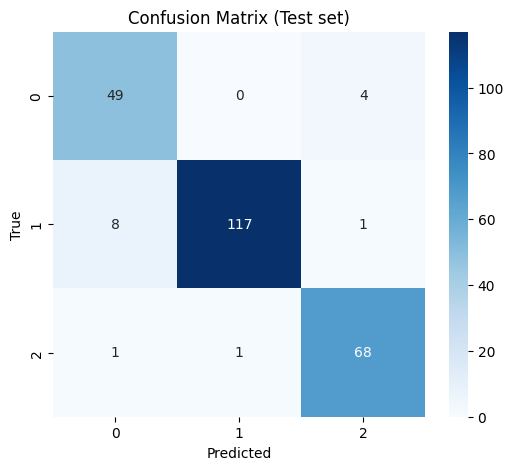


Classification Report:
              precision    recall  f1-score   support

           0      0.845     0.925     0.883        53
           1      0.992     0.929     0.959       126
           2      0.932     0.971     0.951        70

    accuracy                          0.940       249
   macro avg      0.923     0.942     0.931       249
weighted avg      0.943     0.940     0.941       249



In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
out = model(data.x, data.edge_index)
pred = out.argmax(dim=1).cpu().numpy()
true = data.y.cpu().numpy()

test_mask = data.test_mask.cpu().numpy().astype(bool)
pred_test = pred[test_mask]
true_test = true[test_mask]

cm = confusion_matrix(true_test, pred_test)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Test set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\nClassification Report:")
print(classification_report(true_test, pred_test, digits=3))


In [15]:
model.eval()
with torch.no_grad():
    x_emb = model.conv1(data.x, data.edge_index).cpu().numpy()

print(x_emb.shape)

(734, 64)


### 7. Comparison with Baseline Models

After evaluating our simple GCN model, we can compare its performance with baseline solutions based on classical graph metrics and standard ML models:

**Baseline (PageRank, Closeness, Betweenness, Random Walk features + RF / MLP):**

| Model          | Accuracy | F1-score |
|----------------|----------|----------|
| Random Forest  | 0.858    | 0.736    |
| MLP            | 0.898    | 0.846    |

**Simple GCN:**

| Class | Precision | Recall | F1-score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.845     | 0.925  | 0.883    | 53      |
| 1     | 0.992     | 0.929  | 0.959    | 126     |
| 2     | 0.932     | 0.971  | 0.951    | 70      |
| **Overall Accuracy** |           |        | **0.940** | 249 |

**Analysis:**

- The simple GCN model **outperforms baseline models** in both accuracy and F1-score.  
- Baseline Random Forest and MLP already show reasonably strong results (accuracy ~0.86–0.90), but they rely on manually computed graph metrics.  
- The GCN learns embeddings **directly from the graph structure and node features**, which allows it to better capture complex dependencies between countries.  
- Class-wise analysis shows that the GCN performs particularly well for class 1 and 2, with high precision and recall, and a small drop for class 0 (slightly lower precision but still high recall).  
Overall, using a GCN enables the model to **generalize better to test nodes**, likely capturing non-linear interactions between features and graph connectivity that traditional baselines cannot fully exploit.

#### 7.1. **UMAP Visualization**  
To better understand the learned embeddings, we reduce their dimensionality using UMAP to 2D.  
   - This allows visualizing clusters of countries based on their digital profiles.  
   - We can color points by predicted clusters, true clusters, or other metadata (e.g., year) to inspect alignment and trends visually. 

c:\Users\aldir\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


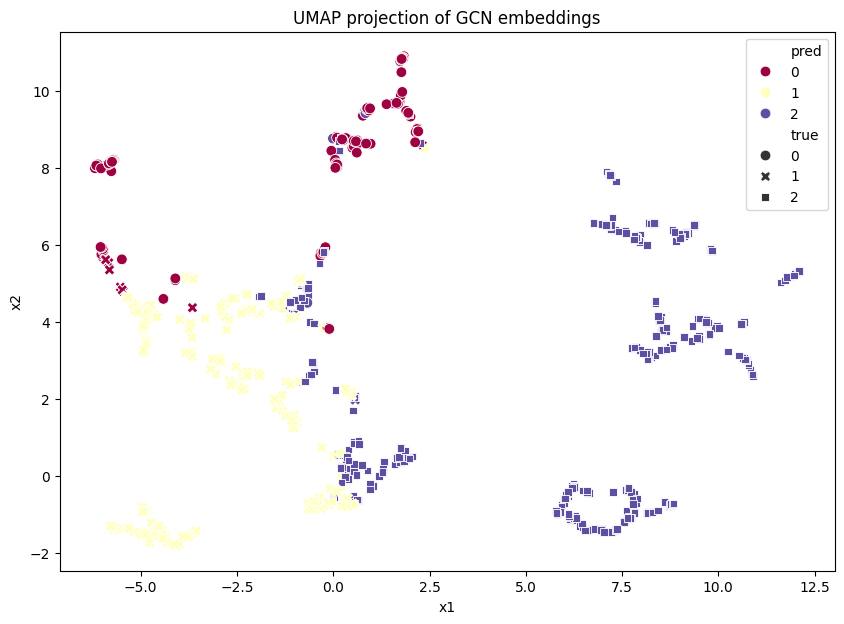

In [17]:
import umap.umap_ as umap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

x_umap = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42).fit_transform(x_emb)

df_emb = pd.DataFrame({
    "x1": x_umap[:,0],
    "x2": x_umap[:,1],
    "true": data.y.cpu().numpy(),
    "pred": model(data.x, data.edge_index).argmax(dim=1).cpu().numpy()
})

plt.figure(figsize=(10,7))
sns.scatterplot(data=df_emb, x="x1", y="x2", hue="pred", style="true", palette="Spectral", s=60)
plt.title("UMAP projection of GCN embeddings")
plt.show()


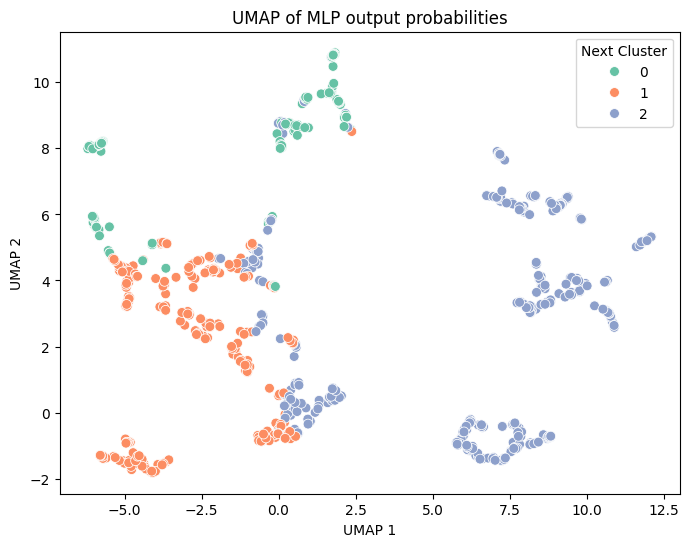

In [19]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=x_umap[:,0], y=x_umap[:,1], hue=model(data.x, data.edge_index).argmax(dim=1).cpu().numpy(), palette='Set2', s=50)
plt.title("UMAP of MLP output probabilities")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title='Next Cluster')
plt.show()

### 8. Saving the Model

Finally, we save the trained GCN for future use (comparsion with TemporalGNN and complex GNNs, or interpretability analysis).

In [49]:
torch.save(model, "../models/simple_gcn_model.pth")

### 9. Summary: Takeaways and Future Steps

**Takeaways:**

- Moving from baseline feature-engineered approaches to a GCN provides a **clear improvement in predictive performance**.  
- This justifies proceeding with further experiments on **improved GNN architectures** and **temporal extensions** to capture dynamics over time.

**Future Steps:**

1. **Temporal GNN (Dynamic Graphs)**  
   - Extend the model to account for **temporal evolution of countries’ digital profiles** across years.  
   - Incorporate the sequence of graphs over time to predict **future changes in clusters**, including potential transitions of countries between underdeveloped and advanced clusters.

2. **Model Interpretability**  
   - Use tools like **GNNExplainer** or **PyG’s Explainer API** to understand which features and connections are most influential for cluster assignments.  
   - Investigate **node and edge importance**, which can highlight the most critical indicators of digital development.

3. **Future Cluster Prediction**  
   - Use the trained model to **predict the future distribution of countries across clusters**, based on current trends and historical dynamics.  
   - Identify **emerging digital leaders** and **lagging countries** for targeted analysis or policy recommendations.

4. **Visualization & Analysis**  
   - Apply **UMAP or t-SNE** on learned embeddings to visualize how clusters evolve over time.  
   - Compare temporal dynamics predicted by GNN with historical trends to validate model reliability.

5. **Potential Improvements**  
   - Experiment with **deeper or multi-layer GNN architectures** to capture more complex relationships.  
   - Test **different aggregation functions, residual connections, and attention mechanisms** for better representation learning.
   - **Hyperparameters tuning**  